In [1]:
import theano
import numpy as np

import joblib

from braindecode.veganlasagne.layer_util import print_layers
from braindecode.analysis.plot_util import plot_head_signals_tight,plot_head_signals_tight_with_tube
from braindecode.datasets.sensor_positions import tight_cap_positions
import lasagne
import scipy

import os

%load_ext autoreload
%autoreload 2

Using gpu device 0: GeForce GTX 780 (CNMeM is disabled, cuDNN 5005)


In [2]:
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
import convvisual.receptive_field.receptive_field as receptive_field
import convvisual.analysis.analysis as analysis
import convvisual.analysis.utils as utils
import convvisual.analysis.plot as plot

/home/hartmank/braindecode/vienv/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
modelpath = '/home/hartmank/braindecode/data/models/'
modelname = 'paper/ours/cnt/deep4/car/22'
savepath  = '/home/hartmank/data/convvisual/RF_data/'

In [5]:
import os
n_class_inputs = 50
max_baseline_inputs = 2500 # Number of signal windows used for baseline
wins_per_input = 3
num_KS = 100
fig_h = 10

In [12]:
def make_data(RF_Result,n_chans):
    indexer = {'FFT':0,'FFTc':1,'Phase':2,'Phasec':3,'Mean':4,'Meanc':5,'Power':6}
    RF_Result.max_filters = RF_Result.max_filters
    c = False
    KS_scores = list()
    counts = np.zeros((7,len(RF_Result.max_filters)))
    max_channels = np.zeros((len(RF_Result.max_filters)),dtype=int)
    for i,filt in enumerate(RF_Result.max_filters):
        X_RF_cropped = utils.get_RF(RF_Result,i,n_chans)[:n_class_inputs]
        if not c:
            X_baseline = utils.cut_baseline(RF_Data.inputs,wins_per_input,X_RF_cropped.shape)[:max_baseline_inputs]
            c = True

        feat_KS,feat_p,feat_labels,feat_class,feat_base = utils.extract_features_and_diff(X_RF_cropped,X_baseline,sampling_rate)
        KS_sorted = np.argsort(feat_KS)[::-1]
        KS_sorted = KS_sorted[feat_p[KS_sorted]<0.05]
        KS_sorted = KS_sorted[KS_sorted>0.5]
                
        max_channels[i] = feat_labels[KS_sorted[:10]][0][1][0]

        counter = {'FFT':0,'FFTc':0,'Phase':0,'Phasec':0,'Mean':0,'Meanc':0,'Power':0}
        for KS_ind in KS_sorted:
            lbl = feat_labels[KS_ind]
            score = feat_KS[KS_ind]
            counter[lbl[0]] += score

        for key,val in counter.items():
            counts[indexer[key],i] = val

    return counts,max_channels

In [7]:
def make_plot(data,max_channels,n_chans):
    rows = ('FFT','FFTc','Phase','Phasec', 'Mean','Meanc','Power')
    columns = ['Filter %d' % x for x in range(data.shape[1])]

    plt.figure(figsize=(data.shape[1]/2,fig_h))

    colors = plt.cm.jet(np.linspace(0, 0.9, data.shape[0]))
    n_rows = len(data)

    index = np.arange(len(columns)) + 0.3
    bar_width = 0.4

    # Initialize the vertical-offset for the stacked bar chart.
    y_offset = np.array([0.0] * len(columns))

    # Plot bars and create text labels for the table
    cell_text = []
    for row in range(n_rows):
        plt.bar(index, data[row], bar_width, bottom=y_offset, color=colors[row])
        y_offset = y_offset + data[row]
        cell_text.append(['%1.1f' % (x) for x in data[row]])
    # Reverse colors and text labels to display the last value at the top.
    colors = colors[::-1]
    cell_text.reverse()
    rows = rows[::-1]

    # Add a table at the bottom of the axes
    the_table = plt.table(cellText=cell_text,
                          rowLabels=rows,
                          rowColours=colors,
                          colLabels=columns,
                          loc='bottom')

    # Adjust layout to make room for the table:
    plt.subplots_adjust(left=0.2, bottom=0.2)

    plt.ylabel('KS Score')
    #plt.yticks(values * value_increment, ['%d' % val for val in values])
    plt.xticks([])
    plt.title('KS Score in Filter by Feature Type (Bonferroni corrected p<0.05, KS>0.5)')
    
    plt.show()
    
    
    plt.figure()
    
    f, axes = plt.subplots(1, data.shape[1], sharey=True, figsize=(data.shape[1],fig_h/4))
    for i,ax in enumerate(axes):
        X_RF_cropped = utils.get_RF(RF_Result,i,n_chans)[:n_class_inputs]
        targets_ind = RF_Result.max_units_in_filters[:,1]==i
        targets = RF_Data.targets[RF_Result.max_units_in_filters[targets_ind,0]][:n_class_inputs]
        plt.sca(ax)
        plot.plot_channel_avg(X_RF_cropped,max_channels[i])
        plt.xticks([])
        plt.xlabel(i)
        plt.ylabel('')
        plt.ylim([-100,100])
        plt.title('%s\n%s'%(sensor_names[max_channels[i]],np.bincount(targets,minlength=4)),fontsize=8)
    plt.show()

### Layer 03

In [8]:
RF_Data = receptive_field.load_ExtractorData(os.path.join(savepath,modelname,'ClassAnalysis_AllFilters_NoClass_nUnits200'))
RF_Result = receptive_field.load_ClassData(os.path.join(savepath,modelname,'ClassAnalysis_AllFilters_NoClass_nUnits200'),3,None)

n_chans = RF_Data.n_chans
sensor_names = RF_Data.sensor_names
sampling_rate = RF_Data.sampling_rate

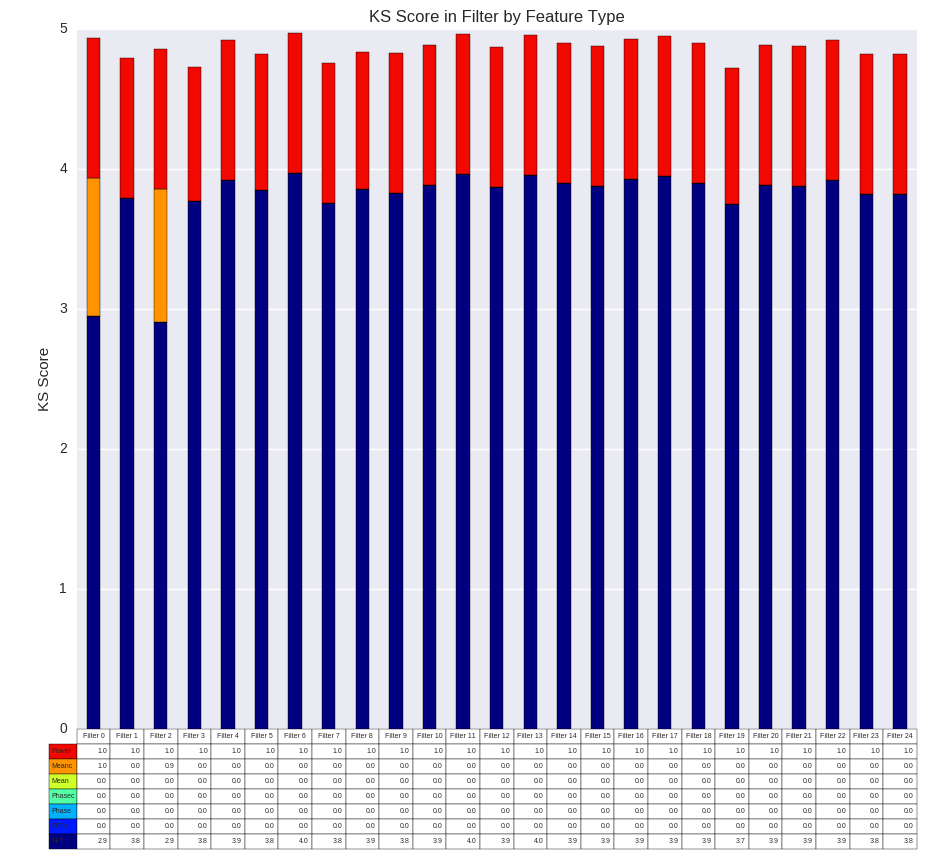

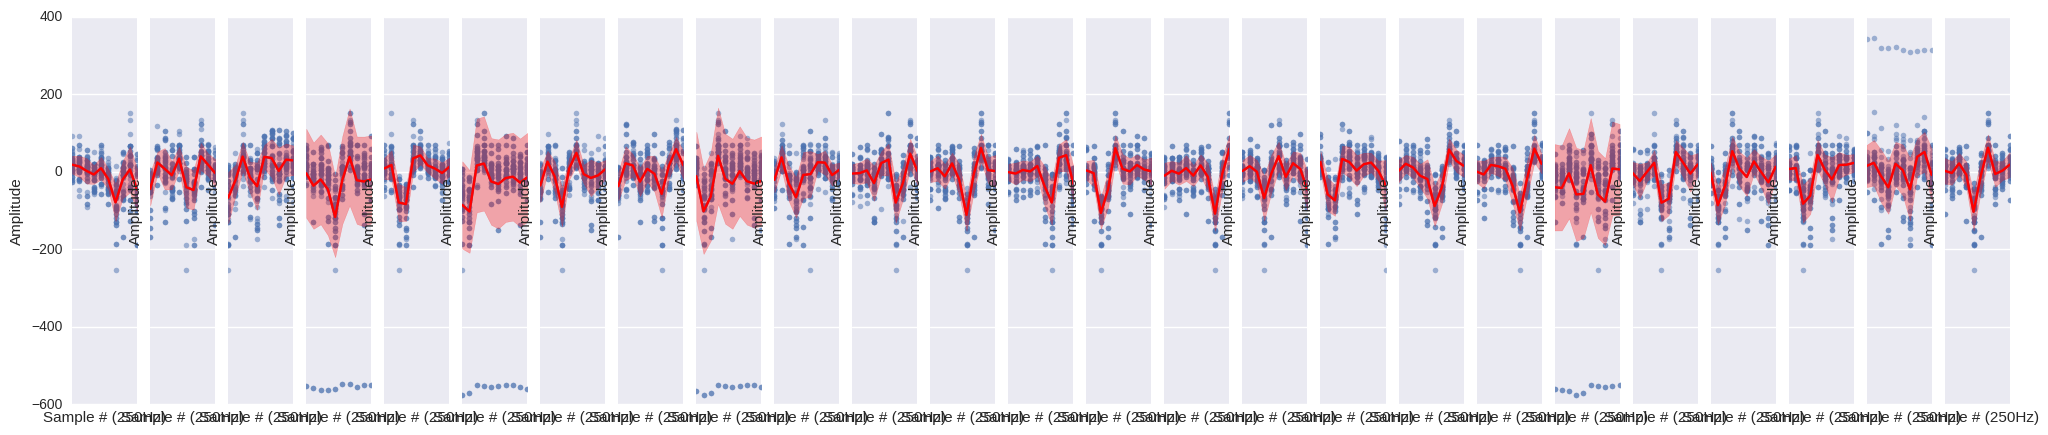

In [27]:
data,max_channels = make_data(RF_Result,1)
make_plot(data,max_channels,1)

### Layer 04

In [8]:
RF_Data = receptive_field.load_ExtractorData(os.path.join(savepath,modelname,'ClassAnalysis_AllFilters_NoClass_nUnits200'))
RF_Result = receptive_field.load_ClassData(os.path.join(savepath,modelname,'ClassAnalysis_AllFilters_NoClass_nUnits200'),4,None)

n_chans = RF_Data.n_chans
sensor_names = RF_Data.sensor_names
sampling_rate = RF_Data.sampling_rate

[['FFT', [28, 3]] ['FFT', [28, 2]] ['FFT', [36, 2]] ['FFT', [19, 4]]
 ['FFT', [38, 3]] ['FFT', [38, 2]] ['FFT', [19, 2]] ['FFT', [27, 2]]
 ['FFT', [19, 3]] ['FFT', [27, 4]] ['FFT', [47, 2]] ['FFT', [37, 2]]
 ['FFT', [28, 4]] ['FFT', [36, 3]] ['Power', [38]] ['FFT', [36, 4]]
 ['FFT', [26, 2]] ['Meanc', [28]] ['FFT', [27, 3]] ['Power', [28]]
 ['Power', [36]] ['FFT', [18, 4]] ['FFT', [25, 2]] ['Power', [27]]
 ['Meanc', [27]] ['FFT', [26, 4]] ['FFT', [25, 3]] ['Meanc', [19]]
 ['FFT', [18, 2]] ['FFT', [17, 2]] ['FFT', [12, 4]] ['FFT', [26, 3]]
 ['Meanc', [36]] ['FFT', [18, 3]] ['Power', [19]] ['Meanc', [37]]
 ['FFT', [38, 4]] ['FFT', [35, 3]] ['Meanc', [26]] ['FFT', [29, 3]]
 ['FFT', [17, 3]] ['FFT', [25, 4]] ['FFT', [47, 4]] ['FFT', [35, 2]]
 ['FFT', [37, 4]] ['FFT', [37, 3]] ['Meanc', [38]] ['FFT', [47, 3]]
 ['Power', [26]] ['FFT', [46, 2]] ['FFT', [17, 4]] ['Meanc', [18]]
 ['FFT', [12, 2]] ['FFT', [48, 2]] ['FFT', [48, 3]] ['Meanc', [29]]
 ['FFT', [46, 3]] ['Power', [37]] ['Power', [47]]

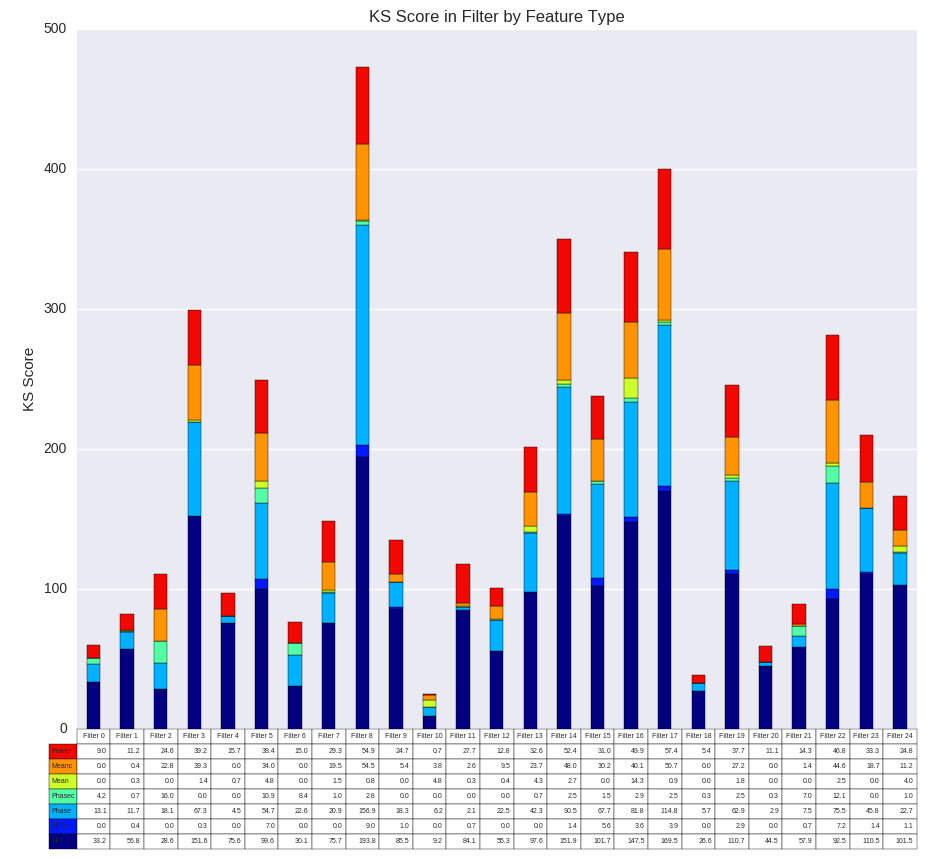

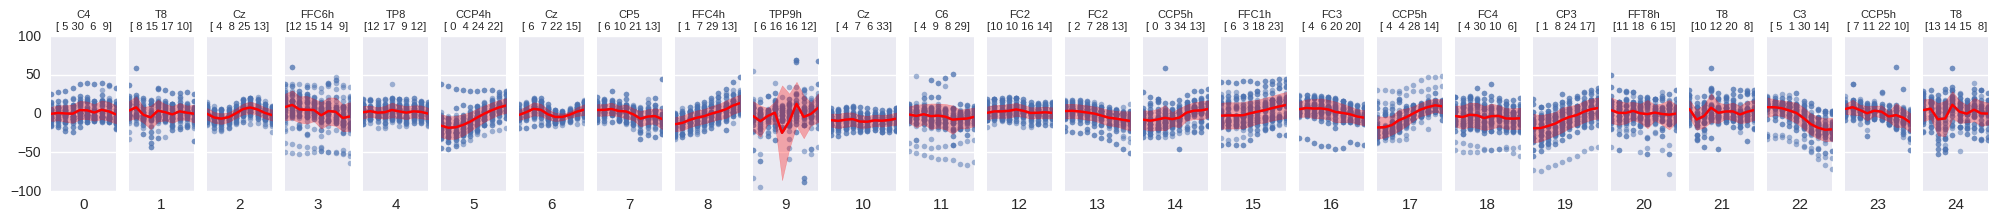

In [13]:
data,max_channels = make_data(RF_Result,n_chans)
make_plot(data,max_channels,n_chans)

### Layer 10

In [30]:
RF_Data = receptive_field.load_ExtractorData(os.path.join(savepath,modelname,'ClassAnalysis_AllFilters_NoClass_nUnits200'))
RF_Result = receptive_field.load_ClassData(os.path.join(savepath,modelname,'ClassAnalysis_AllFilters_NoClass_nUnits200'),10,None)

n_chans = RF_Data.n_chans
sensor_names = RF_Data.sensor_names
sampling_rate = RF_Data.sampling_rate

In [50]:
data,max_channels = make_data(RF_Result,n_chans)
make_plot(data,max_channels,n_chans)

KeyboardInterrupt: 

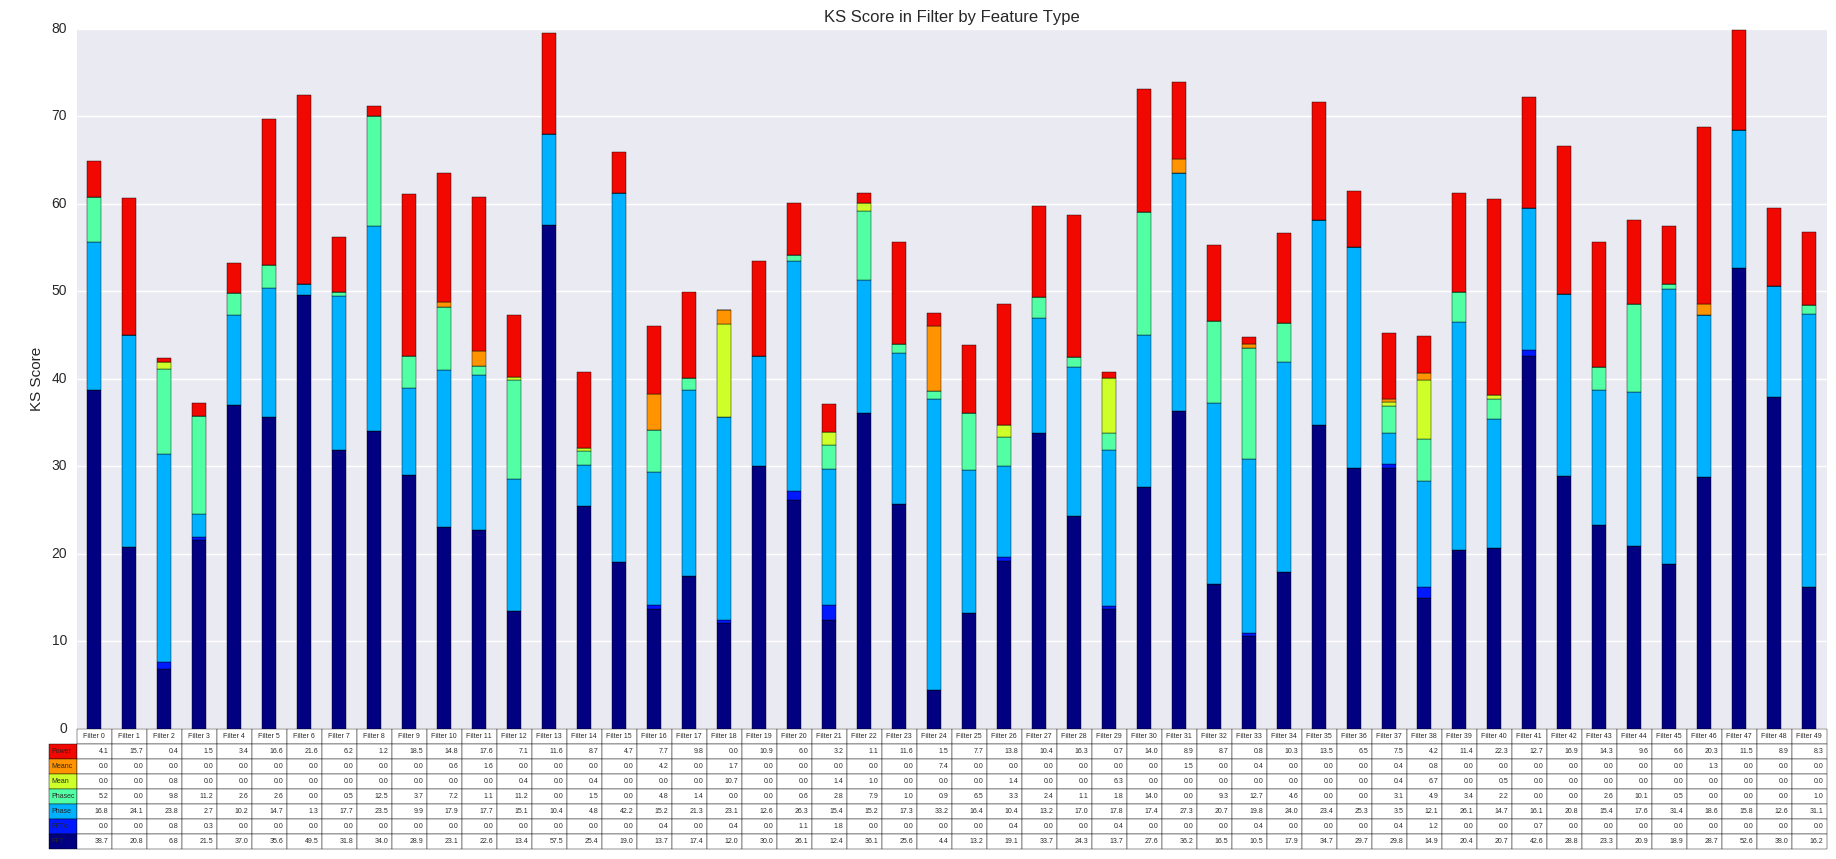

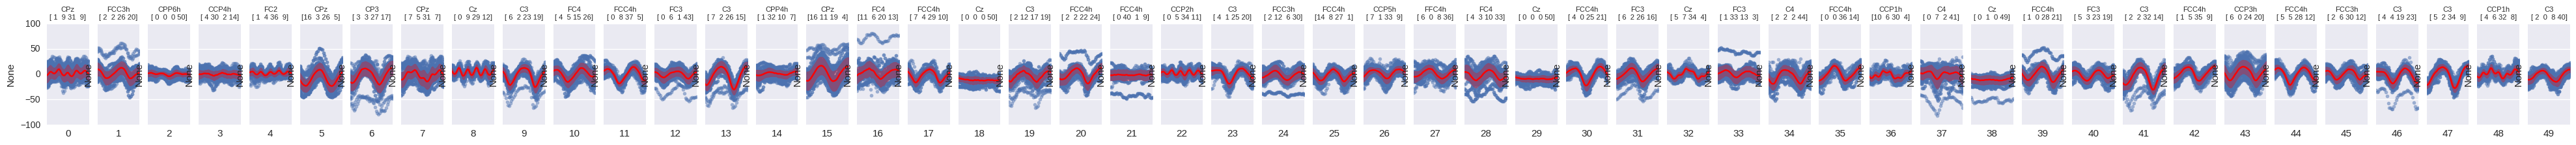

In [55]:
make_plot(data,max_channels,n_chans)

### Layer 16

In [152]:
RF_Data = receptive_field.load_ExtractorData(os.path.join(savepath,modelname,'ClassAnalysis_AllFilters_NoClass_nUnits200'))
RF_Result = receptive_field.load_ClassData(os.path.join(savepath,modelname,'ClassAnalysis_AllFilters_NoClass_nUnits200'),16,None)

n_chans = RF_Data.n_chans
sensor_names = RF_Data.sensor_names
sampling_rate = RF_Data.sampling_rate

In [ ]:
data,max_channels = make_data(RF_Result,n_chans)
make_plot(data,max_channels,n_chans)

### Layer 22

In [152]:
RF_Data = receptive_field.load_ExtractorData(os.path.join(savepath,modelname,'ClassAnalysis_AllFilters_NoClass_nUnits200'))
RF_Result = receptive_field.load_ClassData(os.path.join(savepath,modelname,'ClassAnalysis_AllFilters_NoClass_nUnits200'),22,None)

n_chans = RF_Data.n_chans
sensor_names = RF_Data.sensor_names
sampling_rate = RF_Data.sampling_rate

In [ ]:
data,max_channels = make_data(RF_Result,n_chans)
make_plot(data,max_channels,n_chans)